# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

In [58]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt


***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

In [88]:
file_path = '../data/treasury_quotes_2024-10-31.xlsx'
selected_quotes = pd.read_excel(file_path, sheet_name='selected quotes')
df = selected_quotes
df

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208042,note,2024-10-31,2023-04-30,2025-04-30,0.495551,0,3.875,99.712500,99.722203,99.717351,0,99.717351,0.044933
1,208129,note,2024-10-31,2023-10-31,2025-10-31,0.999316,0,5.000,100.641406,100.660819,100.651113,0,100.651113,0.043311
2,208213,note,2024-10-31,2024-04-30,2026-04-30,1.494867,0,4.875,100.929688,100.960938,100.945312,0,100.945312,0.042327
3,208302,note,2024-10-31,2024-10-31,2026-10-31,1.998631,0,4.125,99.933594,99.941406,99.937500,0,99.937500,0.041611
4,207875,note,2024-10-31,2022-04-30,2027-04-30,2.494182,0,2.750,96.750000,96.781250,96.765625,0,96.765625,0.041346
5,207960,note,2024-10-31,2022-10-31,2027-10-31,2.997947,0,4.125,99.992188,100.015625,100.003906,0,100.003906,0.041268
6,208044,note,2024-10-31,2023-04-30,2028-04-30,3.496235,0,3.500,97.902344,97.941406,97.921875,0,97.921875,0.041487
7,208132,note,2024-10-31,2023-10-31,2028-10-31,4.000000,0,4.875,102.585938,102.621094,102.603516,0,102.603516,0.041623
8,208216,note,2024-10-31,2024-04-30,2029-04-30,4.495551,0,4.625,101.894531,101.929688,101.912109,0,101.912109,0.041590
9,208305,note,2024-10-31,2024-10-31,2029-10-31,4.999316,0,4.125,99.890625,99.898438,99.894531,0,99.894531,0.041496


### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [93]:
def generate_semiannual_coupon_dates(issue_date, maturity_date):
    all_dates = pd.date_range(
        start=issue_date,
        end=maturity_date + DateOffset(months=6), 
        freq=DateOffset(months=6)
    )
    if len(all_dates) > 0 and all_dates[0] == issue_date:
        all_dates = all_dates[1:]
    coupon_dates = [d for d in all_dates if d <= maturity_date]
    return coupon_dates

def build_cashflow_matrix(
    treasury_data, 
    face_value=100.0, 
    payment_frequency_months=6, 
    remove_empty_columns=True
):
   
    data = treasury_data.copy()
    data['issue date']    = pd.to_datetime(data['issue date'])
    data['maturity date'] = pd.to_datetime(data['maturity date'])

    earliest_issue = data['issue date'].min()
    latest_maturity = data['maturity date'].max()

    all_dates = pd.date_range(
        start=earliest_issue,
        end=latest_maturity + DateOffset(months=payment_frequency_months),
        freq=DateOffset(months=payment_frequency_months)
    )

    all_dates = pd.Index(sorted(set(all_dates.union(data['maturity date']))))
    CF = pd.DataFrame(0.0, index=data.index, columns=all_dates)

    for i, row in data.iterrows():
        issue_dt    = row['issue date']
        maturity_dt = row['maturity date']
        annual_rate = row['cpn rate']
        if annual_rate > 1.0:
            annual_rate /= 100.0
        
        semiannual_coupon = annual_rate * face_value / 2.0
        cpn_dates = generate_semiannual_coupon_dates(issue_dt, maturity_dt)
        for cdate in cpn_dates:
            CF.loc[i, cdate] += semiannual_coupon
        CF.loc[i, maturity_dt] += face_value

    if remove_empty_columns:
        CF = CF.loc[:, (CF != 0).any(axis=0)]
    
    return CF
    
CF_matrix = build_cashflow_matrix(
        treasury_data=df, 
        face_value=100.0, 
        payment_frequency_months=6, 
        remove_empty_columns=True
)
CF_matrix = CF_matrix.reindex(sorted(CF_matrix.columns), axis=1)
CF_matrix

,2022-10-30,2023-04-30,2023-10-30,2024-04-30,2024-10-30,2025-04-30,2025-10-30,2025-10-31,2026-04-30,2026-10-30,...,2028-10-31,2029-04-30,2029-10-30,2029-10-31,2030-04-30,2030-10-30,2030-10-31,2031-04-30,2031-10-30,2031-10-31
0,0.000,0.0000,1.9375,1.9375,1.9375,101.9375,0.0000,0.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
1,0.000,0.0000,0.0000,2.5000,2.5000,2.5000,2.5000,100.0,0.0000,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
2,0.000,0.0000,0.0000,0.0000,2.4375,2.4375,2.4375,0.0,102.4375,0.0000,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
3,0.000,0.0000,0.0000,0.0000,0.0000,2.0625,2.0625,0.0,2.0625,2.0625,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
4,1.375,1.3750,1.3750,1.3750,1.3750,1.3750,1.3750,0.0,1.3750,1.3750,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
5,0.000,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,0.0,2.0625,2.0625,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
6,0.000,0.0000,1.7500,1.7500,1.7500,1.7500,1.7500,0.0,1.7500,1.7500,...,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
7,0.000,0.0000,0.0000,2.4375,2.4375,2.4375,2.4375,0.0,2.4375,2.4375,...,100.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
8,0.000,0.0000,0.0000,0.0000,2.3125,2.3125,2.3125,0.0,2.3125,2.3125,...,0.0,102.3125,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0
9,0.000,0.0000,0.0000,0.0000,0.0000,2.0625,2.0625,0.0,2.0625,2.0625,...,0.0,2.0625,2.0625,100.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [91]:
def solve_spot_discounts(CF_matrix, prices):
    C = CF_matrix.values 
    p = prices.values    
    if C.shape[0] == C.shape[1]:
        print("Solving Linear Equation")
        z = np.linalg.solve(C, p)
    else:
        print("Using Least Squares to solve the equation")
        z, residuals, rank, s = np.linalg.lstsq(C, p, rcond=None)
    
    z_series = pd.Series(z, index=CF_matrix.columns, name='discount factor')
    return z_series

prices = df['dirty price']  
prices = prices.reindex(CF_matrix.index)
z_series = solve_spot_discounts(CF_matrix, prices)
z_series.to_frame()

Using Least Squares to solve the equation


,discount factor
2022-10-30,0.010237
2023-04-30,0.029222
2023-10-30,0.070034
2024-04-30,0.137679
2024-10-30,0.192754
2025-04-30,0.970609
2025-10-30,0.234103
2025-10-31,0.968133
2026-04-30,0.952181
2026-10-30,0.191806


### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

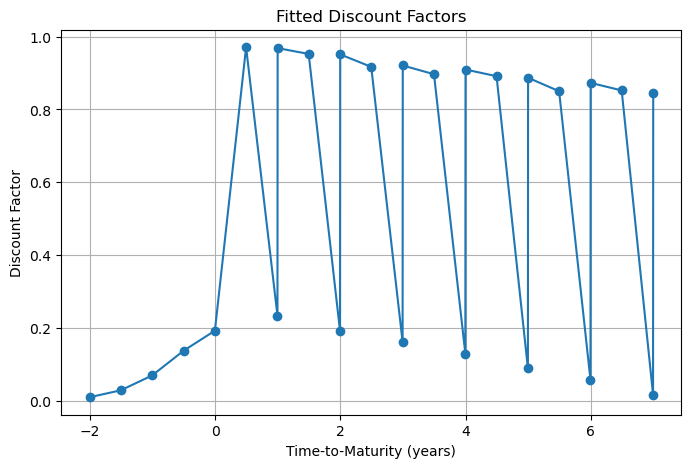

NameError: name 'discount_to_yield' is not defined

In [92]:
valuation_date = df['quote date'].iloc[0]  
plot_df = z_series.to_frame().reset_index()
plot_df.columns = ['date', 'discount factor']
plot_df['maturity'] = (plot_df['date'] - valuation_date).dt.days / 365.25

# Sort by maturity
plot_df.sort_values('maturity', inplace=True)

# Plot discount factors
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(plot_df['maturity'], plot_df['discount factor'], marker='o')
plt.xlabel('Time-to-Maturity (years)')
plt.ylabel('Discount Factor')
plt.title('Fitted Discount Factors')
plt.grid(True)
plt.show()

# 2.6. OPTIONAL: Convert discount factors to yields and plot
plot_df['r_cont'] = plot_df.apply(lambda x: discount_to_yield(x['discount factor'], x['maturity']), axis=1)
plot_df['r_semi'] = plot_df.apply(lambda x: discount_to_semiannual(x['discount factor'], x['maturity']), axis=1)

plt.figure(figsize=(8,5))
plt.plot(plot_df['maturity'], plot_df['r_cont'], 'o-', label='Continuous Yield')
plt.plot(plot_df['maturity'], plot_df['r_semi'], 's-', label='Semiannual Yield')
plt.xlabel('Time-to-Maturity (years)')
plt.ylabel('Yield (decimal)')
plt.title('Implied Spot Yields')
plt.legend()
plt.grid(True)
plt.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.


In [28]:
file_path = '../data/yields.xlsx'
yields_df = pd.read_excel(file_path, sheet_name='yields')
yields_df

,caldt,1,2,5,7,10,20,30
0,1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1,1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
2,1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
3,1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
4,1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018
...,...,...,...,...,...,...,...,...
15718,2024-05-24,5.151637,4.876767,4.477900,4.422071,4.413264,4.641009,4.513753
15719,2024-05-28,5.149635,4.921106,4.550730,4.512302,4.498891,4.737532,4.612964
15720,2024-05-29,5.231355,4.933358,4.603891,4.566732,4.561608,4.802605,4.679462
15721,2024-05-30,5.174662,4.884783,4.537826,4.496453,4.496618,4.744930,4.625810


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [48]:
maturities = list(map(int, yields_df.columns[1:]))

factors = pd.DataFrame(index=yields_df.index)
factors['level'] = yields_df[maturities].mean(axis=1)
factors['slope'] = yields_df[30] - yields_df[1]
factors['curvature'] = -yields_df[1] + 2*yields_df[10] - yields_df[30]
factors.head()

,level,slope,curvature
0,3.591027,0.879264,0.886559
1,3.614691,0.893380,0.966721
2,3.617360,0.900101,0.966566
3,3.630646,0.916659,1.013983
4,3.627267,0.892599,0.975574


In [49]:
correlation_matrix = factors.corr()
correlation_matrix

,level,slope,curvature
level,1.000000,-0.375967,-0.169325
slope,-0.375967,1.000000,0.647671
curvature,-0.169325,0.647671,1.000000


In [53]:
mean_factors = factors.mean()
mean_factors.to_frame().rename(columns={0:"Mean Factors"})

,Mean Factors
level,5.475250
slope,1.109788
curvature,0.671817


In [54]:
vol_factors = factors.std()
vol_factors.to_frame().rename(columns={0:"Vol Factors"})

,Vol Factors
level,2.914725
slope,1.480255
curvature,0.971945


### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [67]:
pca = PCA() 
pca.fit(yields_df[yields_df.columns[1:]])

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio by each component):")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {ratio}\n")

cumulative_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio:")
for i, ratio in enumerate(cumulative_ratio, ):
    print(f"Till PC{i+1}: {ratio}\n")

Explained Variance Ratio by each component):
PC1: 0.970700015166877

PC2: 0.025278256947983514

PC3: 0.0029470210113299662

PC4: 0.000454237470931134

PC5: 0.00037174834268467174

PC6: 0.0001518220034797486

PC7: 9.689905671397735e-05

Cumulative Explained Variance Ratio:
Till PC1: 0.970700015166877

Till PC2: 0.9959782721148605

Till PC3: 0.9989252931261904

Till PC4: 0.9993795305971215

Till PC5: 0.9997512789398062

Till PC6: 0.9999031009432859

Till PC7: 0.9999999999999999



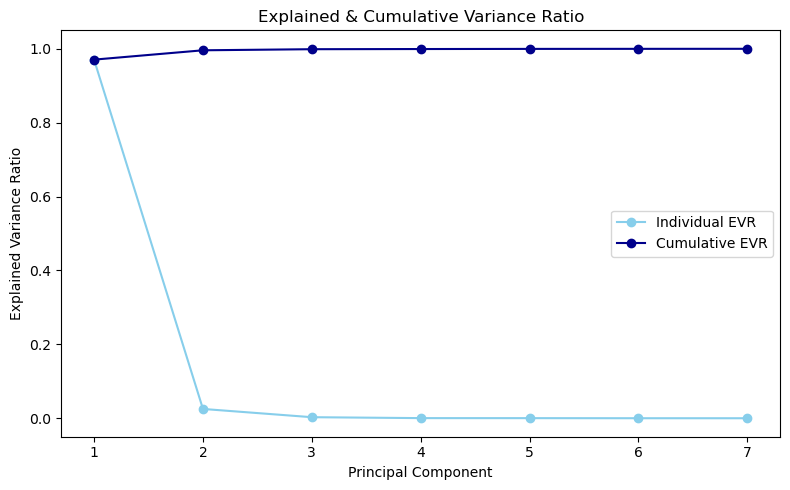

In [68]:
x_axis = np.arange(1, len(explained_variance_ratio) + 1)
plt.figure(figsize=(8, 5))
plt.plot(x_axis, explained_variance_ratio, marker='o', linestyle='-', color='skyblue', 
         label='Individual EVR')
plt.plot(x_axis, cumulative_ratio, marker='o', linestyle='-', color='darkblue', 
         label='Cumulative EVR')

plt.xticks(x_axis) 
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained & Cumulative Variance Ratio')
plt.legend()
plt.tight_layout()
plt.show()

In [72]:
import seaborn as sns
loadings_pc1 = pca.components_[0]
loadings_pc2 = pca.components_[1]
loadings_pc3 =  pca.components_[2]
loadings_df = pd.DataFrame(
    [loadings_pc1, loadings_pc2, loadings_pc3],
    index=['PC1', 'PC2', 'PC3'],
    columns=yields_df.columns[1:]  
)
loadings_df

,1,2,5,7,10,20,30
PC1,0.411464,0.411054,0.392784,0.378353,0.363380,0.344069,0.337450
PC2,-0.591006,-0.399298,-0.046806,0.087439,0.202674,0.438856,0.497760
PC3,0.455496,0.007324,-0.392437,-0.448402,-0.363501,0.363015,0.416516


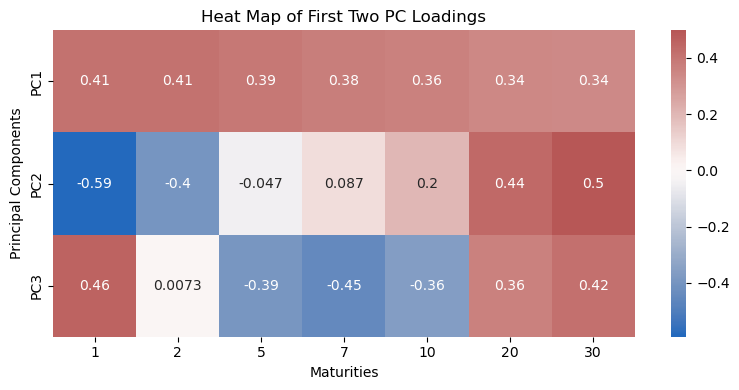

In [73]:
plt.figure(figsize=(8, 4))
sns.heatmap(
    loadings_df, 
    annot=True,       
    cmap='vlag',      
    center=0
)
plt.title('Heat Map of First Two PC Loadings')
plt.ylabel('Principal Components')
plt.xlabel('Maturities')
plt.tight_layout()
plt.show()

### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [77]:
compare_df = pd.concat([factors[['level', 'slope', 'curvature']], loadings_df.T[['PC1', 'PC2', 'PC3']]], axis=1)

corr_matrix = compare_df.corr()
corr_matrix

,level,slope,curvature,PC1,PC2,PC3
level,1.000000,-0.375967,-0.169325,0.067732,0.081878,-0.888205
slope,-0.375967,1.000000,0.647671,-0.697979,0.719813,-0.347836
curvature,-0.169325,0.647671,1.000000,0.653764,-0.564783,-0.682504
PC1,0.067732,-0.697979,0.653764,1.000000,-0.972211,-0.194414
PC2,0.081878,0.719813,-0.564783,-0.972211,1.000000,-0.001032
PC3,-0.888205,-0.347836,-0.682504,-0.194414,-0.001032,1.000000


In [78]:
corr_level_pc1 = corr_matrix.loc['level', 'PC1']
corr_slope_pc2 = corr_matrix.loc['slope', 'PC2']

print(f"Correlation (Ad-hoc level, PC1): {corr_level_pc1:.4f}")
print(f"Correlation (Ad-hoc slope, PC2): {corr_slope_pc2:.4f}")

Correlation (Ad-hoc level, PC1): 0.0677
Correlation (Ad-hoc slope, PC2): 0.7198
